<a href="https://colab.research.google.com/github/tranduytruong12/Assignment_DM/blob/main/DM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Prediction Model Using CNN (Convolutional Neural NetWork)

## Members
1. Trần Duy Trường - 2115155


#Objective
**The primary goal of this project is to develop an efficient and reliable convolutional neural network (CNN) model capable of predicting pneumonia from chest X-ray images. By leveraging advanced deep learning techniques, we aim to assist healthcare professionals in early diagnosis and treatment planning, potentially reducing morbidity and mortality rates.**

#Motivation
**Early detection through chest X-ray analysis can save lives, but is often time-consuming and prone to errors. By automating the detection process with a robust CNN model, we can enhance diagnostic accuracy, alleviate the burden on radiologists, and democratize access to quality healthcare.**

**In addition to addressing a critical medical need, this project serves as an opportunity for our team to gain hands-on experience and deepen our understanding of machine learning (ML), deep learning (DL), and CNN architectures.**

# Pneumonia Definition
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**


# Dataset description
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

**Dataset:** Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification.

**Link:** https://data.mendeley.com/datasets/rscbjbr9sj/2.

# Setup

## Importing the necessary libraries

In [ ]:
%pip install matplotlib seaborn scikit-learn keras tensorflow kagglehub tqdm -q

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from PIL import Image
import cv2
import os
import numpy as np
import pandas as pd
import kagglehub

## Import chest x-ray Pneumonia dataset

In [ ]:
chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
print("Path to dataset files:", chest_xray_pneumonia_path)

100%|██████████| 2.29G/2.29G [01:45<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
for root, dirs, files in os.walk(chest_xray_pneumonia_path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)

Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Directories: ['chest_xray']
Files: []
----------------------------------------
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Directories: ['chest_xray', '__MACOSX', 'test', 'val', 'train']
Files: []
----------------------------------------
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray
Directories: ['test', 'val', 'train']
Files: ['.DS_Store']
----------------------------------------
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test
Directories: ['PNEUMONIA', 'NORMAL']
Files: ['.DS_Store']
----------------------------------------
Root: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test/PNEUMONIA
Directories: []
Files: ['person139_bacteria_662.jpeg', 'person158_bact

In [ ]:
chest_xray_path = os.path.join(chest_xray_pneumonia_path , 'chest_xray')

for split in ['train', 'test', 'val']:
    split_path = os.path.join(chest_xray_path , split)
    print(f"Dataset: {split}")
    total = 0
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(split_path, category)
        num_images = len(os.listdir(category_path))
        print(f"  {category}: {num_images} images")
        total += num_images
    print("  Total:", total)

Dataset: train
  NORMAL: 1341 images
  PNEUMONIA: 3875 images
  Total: 5216
Dataset: test
  NORMAL: 234 images
  PNEUMONIA: 390 images
  Total: 624
Dataset: val
  NORMAL: 8 images
  PNEUMONIA: 8 images
  Total: 16


# Data Visualization & Preprocessing

## Explore dataset

In [ ]:
def check_image_formats(split, category):
    category_path = os.path.join(chest_xray_path, split, category)
    valid_formats = ('.jpg', '.jpeg', '.png')
    invalid_files = [f for f in os.listdir(category_path) if not f.lower().endswith(valid_formats)]
    if invalid_files:
        print(f"Invalid files in {split}/{category}: {invalid_files}")
    else:
        print(f"All files in {split}/{category} are valid.")

# Check formats for both categories
check_image_formats('train', 'NORMAL')
check_image_formats('train', 'PNEUMONIA')

All files in train/NORMAL are valid.
All files in train/PNEUMONIA are valid.


In [ ]:

def show_sample_images(split, category, num_images=5):
    category_path = os.path.join(chest_xray_path, split, category)
    image_files = os.listdir(category_path)[:num_images]

    plt.figure(figsize=(15, 15))
    for i, image_file in enumerate(image_files):
        img = cv2.imread(os.path.join(category_path, image_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(category + '_' + split.upper())
        plt.axis('off')
    plt.show()

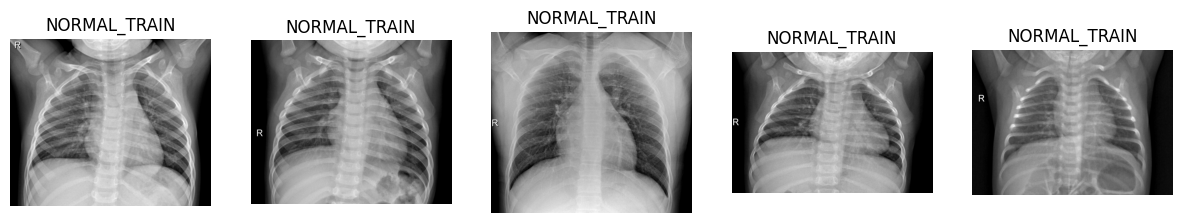

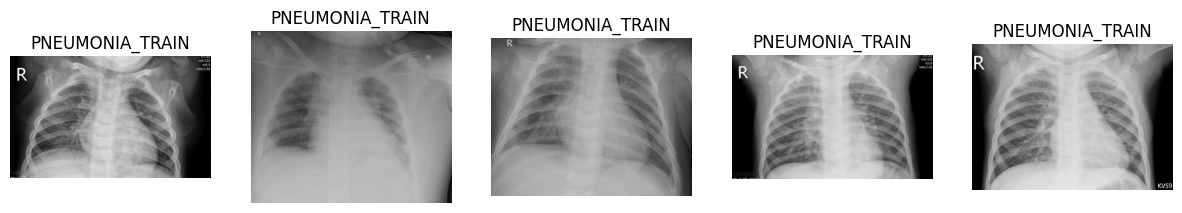

In [ ]:

# Show 5 images from the training set for both NORMAL and PNEUMONIA
show_sample_images('train', 'NORMAL')
show_sample_images('train', 'PNEUMONIA')



NORMAL_train - Mean Dimensions: [1667.73452647 1381.43102163]
NORMAL_train - Standard Deviation: [289.10265845 326.1990408 ]


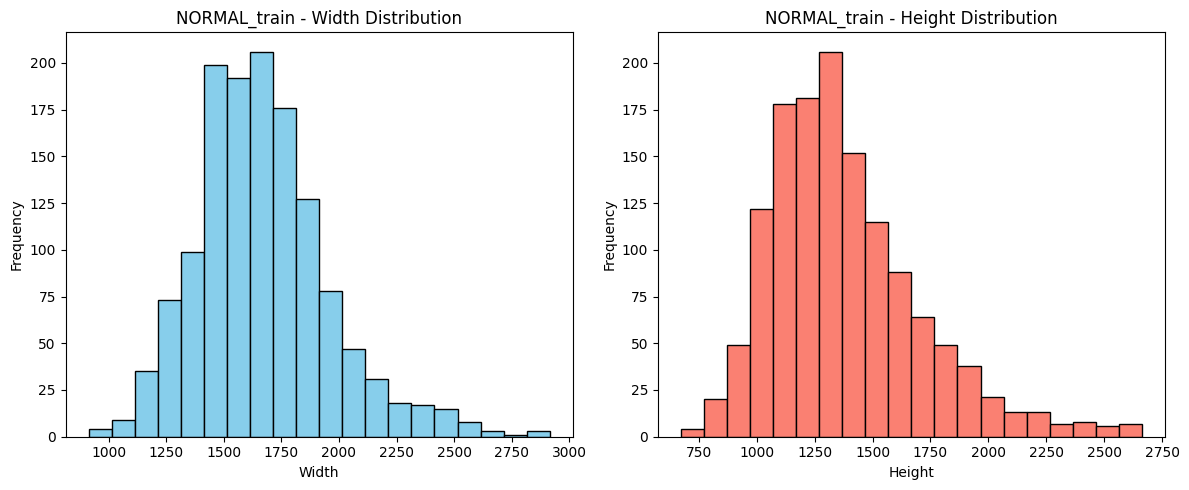

PNEUMONIA_train - Mean Dimensions: [1200.4836129   825.02683871]
PNEUMONIA_train - Standard Deviation: [291.26808567 277.03800471]


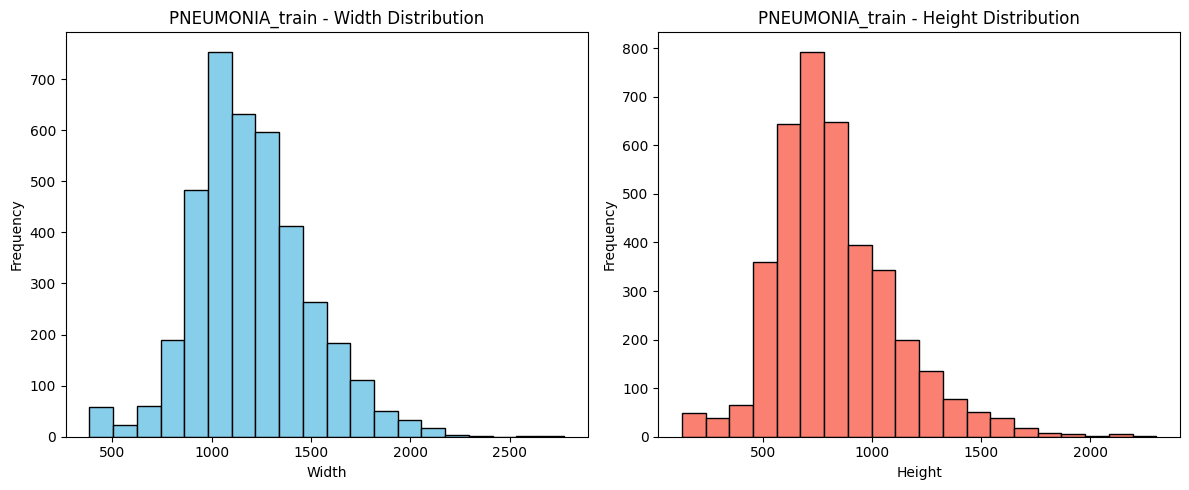

In [ ]:
def analyze_image_dimensions_with_plot(split, category, chest_xray_path):
    # Construct the category path
    category_path = os.path.join(chest_xray_path, split, category)
    image_files = os.listdir(category_path)
    dimensions = []

    # Analyze a subset to save time
    for image_file in image_files[:]:  # Adjust the subset size as needed
        img = Image.open(os.path.join(category_path, image_file))
        dimensions.append(img.size)  # (width, height)

    # Convert dimensions to a NumPy array
    dimensions = np.array(dimensions)

    # Calculate statistics
    mean_dim = dimensions.mean(axis=0)
    std_dim = dimensions.std(axis=0)
    print(f"{category}_{split} - Mean Dimensions: {mean_dim}")
    print(f"{category}_{split} - Standard Deviation: {std_dim}")

    # Plot the distribution of dimensions
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram of widths
    ax[0].hist(dimensions[:, 0], bins=20, color='skyblue', edgecolor='black')
    ax[0].set_title(f"{category}_{split} - Width Distribution")
    ax[0].set_xlabel("Width")
    ax[0].set_ylabel("Frequency")

    # Histogram of heights
    ax[1].hist(dimensions[:, 1], bins=20, color='salmon', edgecolor='black')
    ax[1].set_title(f"{category}_{split} - Height Distribution")
    ax[1].set_xlabel("Height")
    ax[1].set_ylabel("Frequency")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Analyze image dimensions for both categories
analyze_image_dimensions_with_plot(split="train", category="NORMAL", chest_xray_path=chest_xray_path)
analyze_image_dimensions_with_plot(split="train", category="PNEUMONIA", chest_xray_path=chest_xray_path)

## Loading the Dataset

In [ ]:
from tqdm import tqdm
def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0  # Assign class labels
        for img in tqdm(os.listdir(path), desc=f"Processing {label}"):
            try:
                if not img.endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
                    continue
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                if img_arr is None:
                    print(f"Failed to read image: {img_path}")
                    continue
                resized_arr = cv2.resize(img_arr, (224, 224))  # Resize to (224, 224)
                data.append([resized_arr, class_num])  # Add image and label to data
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object)  # Return data as numpy array

In [ ]:
train_dataset_path = os.path.join(chest_xray_path , 'train')
test_dataset_path = os.path.join(chest_xray_path , 'test')
validation_dataset_path = os.path.join(chest_xray_path , 'val')
train = get_training_data(train_dataset_path)
test = get_training_data(test_dataset_path)
val = get_training_data(validation_dataset_path)

Processing PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 298.28it/s]


In [ ]:
print("Number data of training set: ",train.shape[0])
print("Shape of image: ",train[0][0].shape)

Number data of training set:  5216
Shape of image:  (224, 224)


## Visualization

###**Images of trainning data**

In [ ]:
import random
def visualize_samples(dataset, indices, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        idx = indices[i]
        img, label = dataset[idx]
        ax.imshow(img, cmap='gray')
        ax.set_title("NORMAL" if label == 0 else "PNEUMONIA")
        ax.axis('off')
    plt.show()

# Function to visualize edges
def visualize_edges(dataset, indices, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        idx = indices[i]
        img, label = dataset[idx]
        edges = cv2.Canny(img, threshold1=30, threshold2=100)
        ax.imshow(edges, cmap='gray')
        ax.set_title("NORMAL" if label == 0 else "PNEUMONIA")
        ax.axis('off')
    plt.show()

# Fix the random seed and generate indices
random_state = 42
num_samples = 5
random.seed(random_state)  # Set the seed for reproducibility
indices = random.sample(range(len(train)), num_samples)  # Select consistent random indices

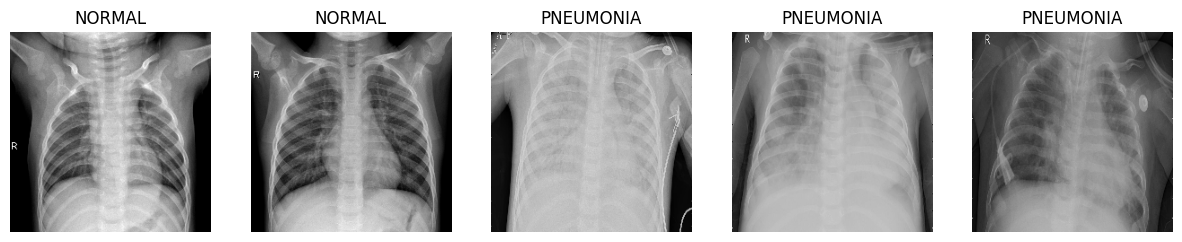

In [ ]:
visualize_samples(train, indices, num_samples)

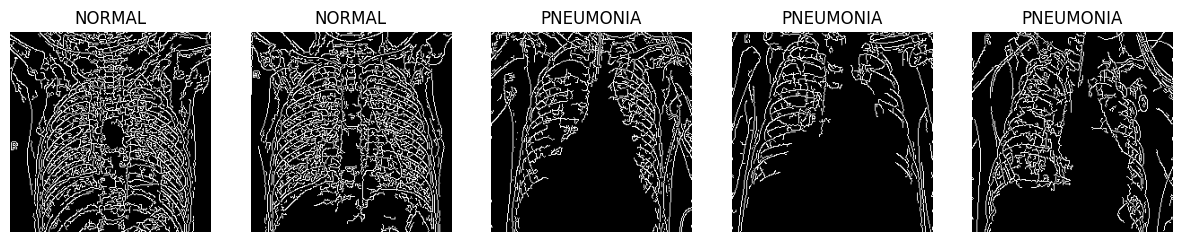

In [ ]:
visualize_edges(train, indices, num_samples)

*Highlight key boundaries and features in the images.*

**Compare image before and after resize**

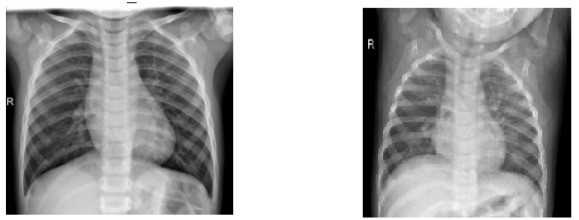

### **Heatmap**


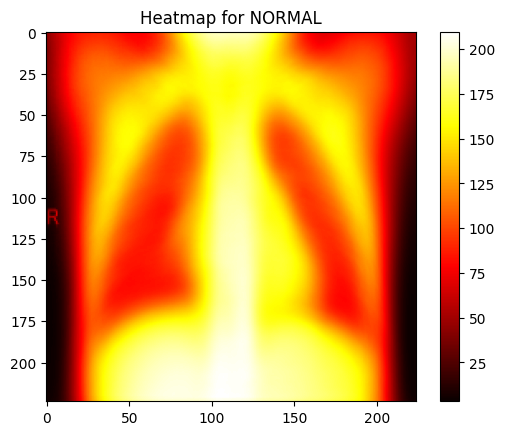

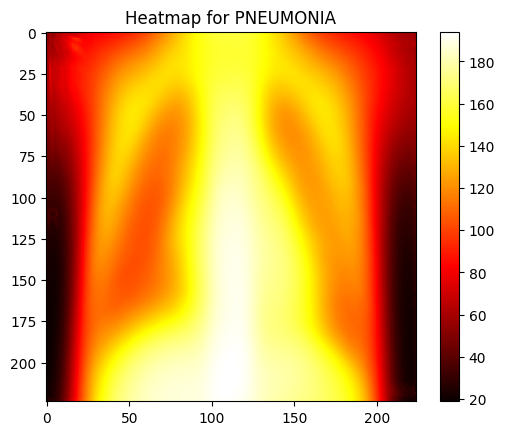

In [ ]:
def generate_heatmap(dataset, label):
    imgs = np.array([img for img, lbl in dataset if lbl == label])
    avg_img = np.mean(imgs, axis=0)
    plt.imshow(avg_img, cmap='hot')
    plt.title(f"Heatmap for {'NORMAL' if label == 0 else 'PNEUMONIA'}")
    plt.colorbar()
    plt.show()

generate_heatmap(train, 0)  # NORMAL
generate_heatmap(train, 1)  # PNEUMONIA

###**Pixel Intensity Distribution**

TRAINING SET
Mean pixel value: 122.89
Standard deviation of pixel values: 60.52
TEST SET
Mean pixel value: 120.95
Standard deviation of pixel values: 60.47
VALIDATION SET
Mean pixel value: 124.85
Standard deviation of pixel values: 65.34


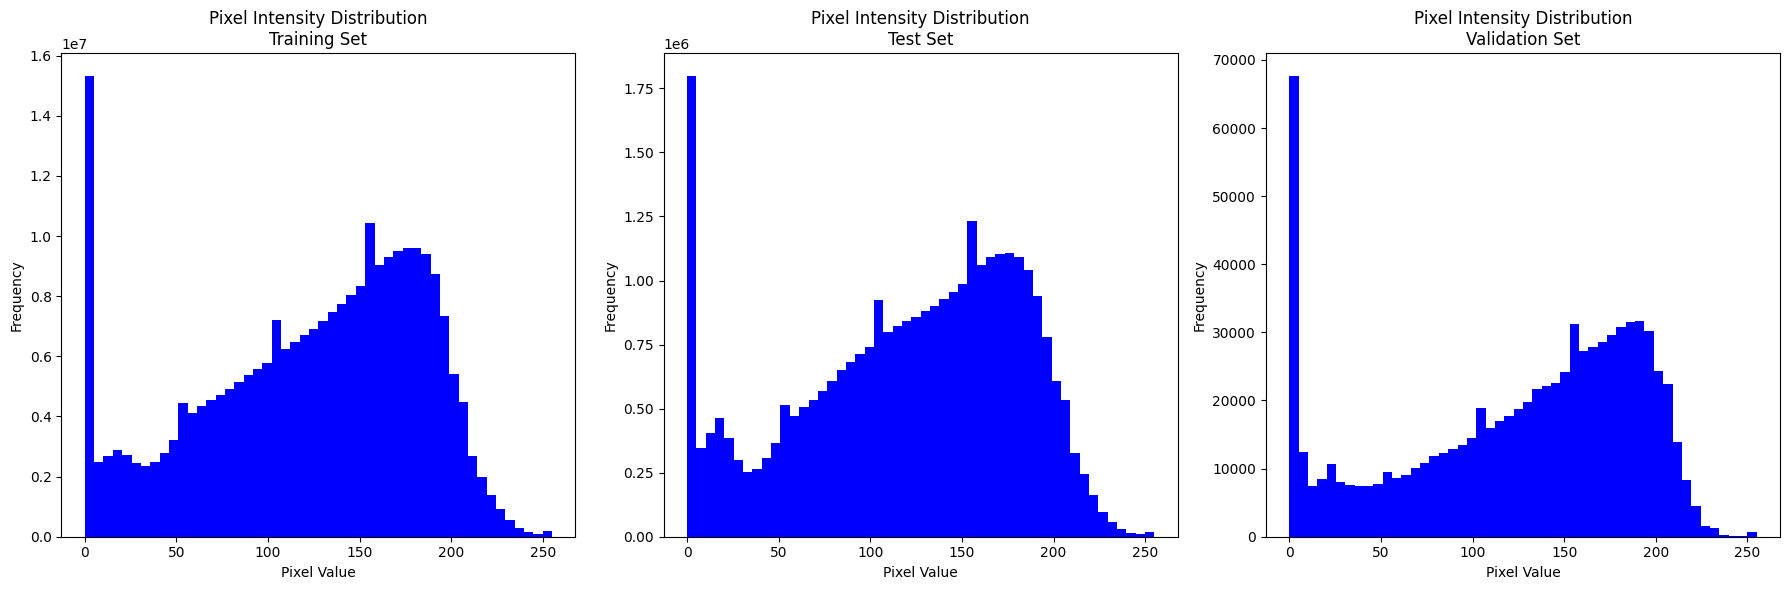

In [ ]:
def pixel_intensity_distribution(dataset, name, ax):
    """Plots pixel intensity distribution on the given axis."""
    pixels = np.array([img.flatten() for img, _ in dataset]).flatten()
    ax.hist(pixels, bins=50, color='blue')
    ax.set_title("Pixel Intensity Distribution\n" + name)
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")

def compute_statistics(dataset, name):
    """Computes and prints pixel intensity statistics."""
    pixels = np.array([img.flatten() for img, _ in dataset]).flatten()
    print(name.upper())
    print(f"Mean pixel value: {np.mean(pixels):.2f}")
    print(f"Standard deviation of pixel values: {np.std(pixels):.2f}")

# Plot all distributions in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

pixel_intensity_distribution(train, 'Training Set', axs[0])
compute_statistics(train, 'Training set')

pixel_intensity_distribution(test, 'Test Set', axs[1])
compute_statistics(test, 'Test set')

pixel_intensity_distribution(val, 'Validation Set', axs[2])
compute_statistics(val, 'Validation set')

plt.tight_layout()  # Adjust spacing between plots
plt.show()


### **Split dataset to images, labels**

In [ ]:
# Normalize images
X_train = np.array([item[0] / 255.0 for item in train])  # Training images
X_test = np.array([item[0] / 255.0 for item in test])    # Test images
X_val = np.array([item[0] / 255.0 for item in val])      # Validation images
# Reshape
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

y_train = np.array([item[1] for item in train])  # Training labels
y_test = np.array([item[1] for item in test])    # Test labels
y_val = np.array([item[1] for item in val])      # Validation labels

In [ ]:
print(X_train.shape)

(5216, 224, 224, 1)


### **Class Distribution**

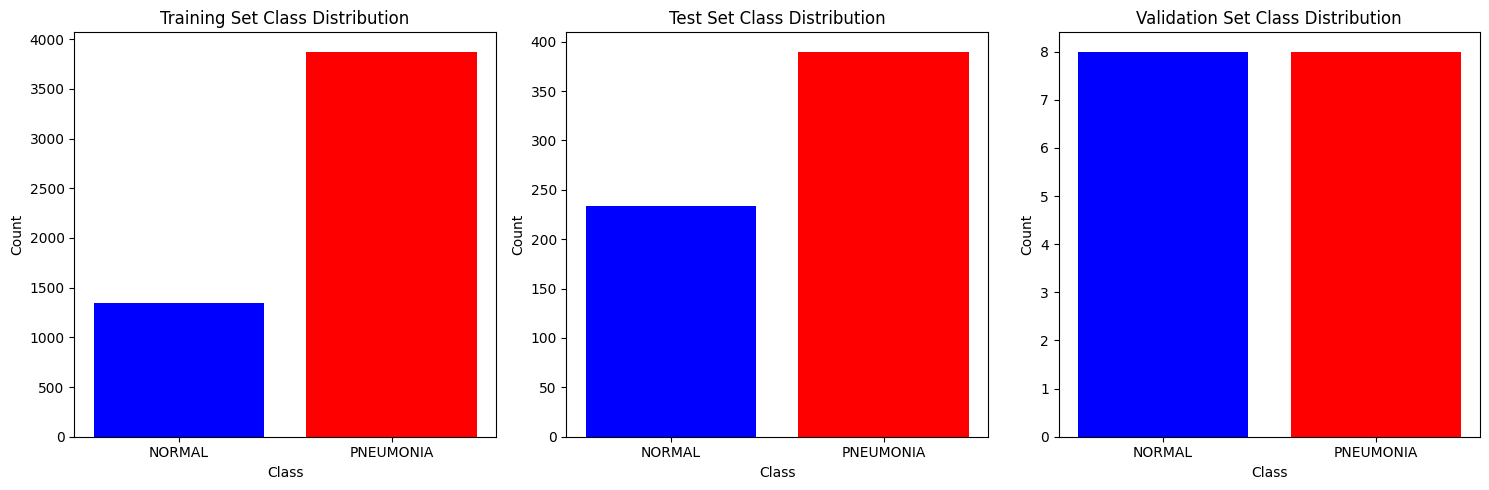

In [ ]:
def plot_class_distribution(ax, labels, title):
    classes, counts = np.unique(labels, return_counts=True)
    ax.bar(['NORMAL', 'PNEUMONIA'], counts, color=['blue', 'red'])
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

# Create a single row of 3 plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # (width, height)

plot_class_distribution(axes[0], y_train, "Training Set Class Distribution")
plot_class_distribution(axes[1], y_test, "Test Set Class Distribution")
plot_class_distribution(axes[2], y_val, "Validation Set Class Distribution")

# Adjust layout to fit all plots properly
plt.tight_layout()
plt.show()

*The data seems imbalanced . To increase the no. of training examples, we will use data augmentation*

# 3.Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

***Example of data augmentation***

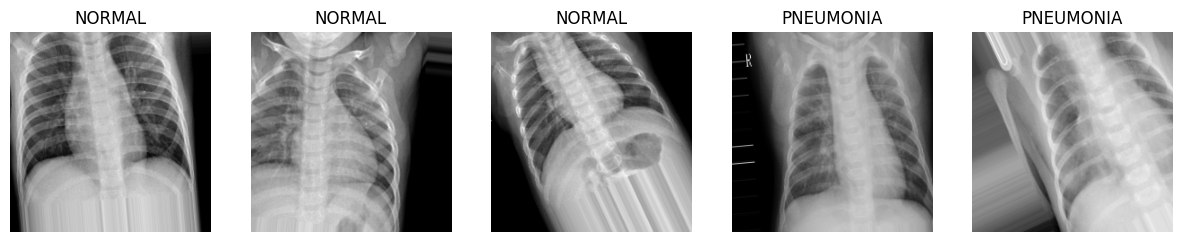

In [ ]:
def visualize_augmentations(dataset, augmentations, num_samples=5):
    datagen = ImageDataGenerator(**augmentations)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img = img.reshape((1,) + img.shape + (1,))  # Add batch and channel dimension
        augmented_img = next(datagen.flow(img, batch_size=1))[0]
        ax.imshow(augmented_img.squeeze(), cmap='gray')
        ax.set_title("NORMAL" if label == 0 else "PNEUMONIA")
        ax.axis('off')

    plt.show()

augmentations = {'rotation_range': 30, 'width_shift_range': 0.2, 'height_shift_range': 0.2}
visualize_augmentations(train, augmentations)

**With data augmentation to prevent overfitting and handling the lack of data in dataset**

###**Generator feature**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

For the data augmentation:
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# 4.Training the Model

### **Create model**

In [ ]:
from tensorflow.keras.regularizers import l2

# Create the model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Third Convolutional Block
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Fourth Convolutional Block
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Fifth Convolutional Block
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))

# Flatten the output and add fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │              

 Total params: 2,032,833 (7.75 MB)

 Trainable params: 2,031,745 (7.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

### **Trainning session**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(
    datagen.flow(X_train,y_train, batch_size = 32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_reduction]  # Pass the callback here
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.8583 - loss: 0.7521 - val_accuracy: 0.5000 - val_loss: 19.3068 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9145 - loss: 0.2157 - val_accuracy: 0.5000 - val_loss: 14.8370 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9215 - loss: 0.2096
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9215 - loss: 0.2095 - val_accuracy: 0.5000 - val_loss: 2.9835 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.9386 - loss: 0.1565 - val_accuracy: 0.5000 - val_loss: 10.9737 - learning_rate: 3.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9467 - loss: 0.1466
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 

### **Test session**

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9075 - loss: 0.2555
Loss of the model is -  0.2660393714904785
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9075 - loss: 0.2555
Accuracy of the model is -  90.06410241127014 %


# Transfer learning (Can not run due to RAM overloaded)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def create_transfer_model(img_size=224):
    # Load ResNet50 pre-trained on ImageNet, without the top fully connected layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freeze the layers of ResNet50 to prevent them from training
    base_model.trainable = False

    # Create a custom model
    model = models.Sequential()
    model.add(base_model)  # Add the pre-trained ResNet50 model
    model.add(layers.GlobalAveragePooling2D())  # Global Average Pooling
    model.add(layers.Dense(128, activation='relu'))  # Fully connected layer
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification (Normal or Pneumonia)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model using transfer learning
model = create_transfer_model(img_size=224)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model using augmented data
X_train = np.repeat(X_train, 3, axis=-1)  # Converts (None, 224, 224, 1) -> (None, 224, 224, 3)
X_val = np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
print(X_train.shape)

(5216, 224, 224, 3)
[0.5254902 0.5254902 0.5254902]


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(
    X_train,y_train, batch_size = 32,
    epochs=5,  # Number of epochs
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[learning_rate_reduction]  # Learning rate scheduler
)

# Analysis after Model Training

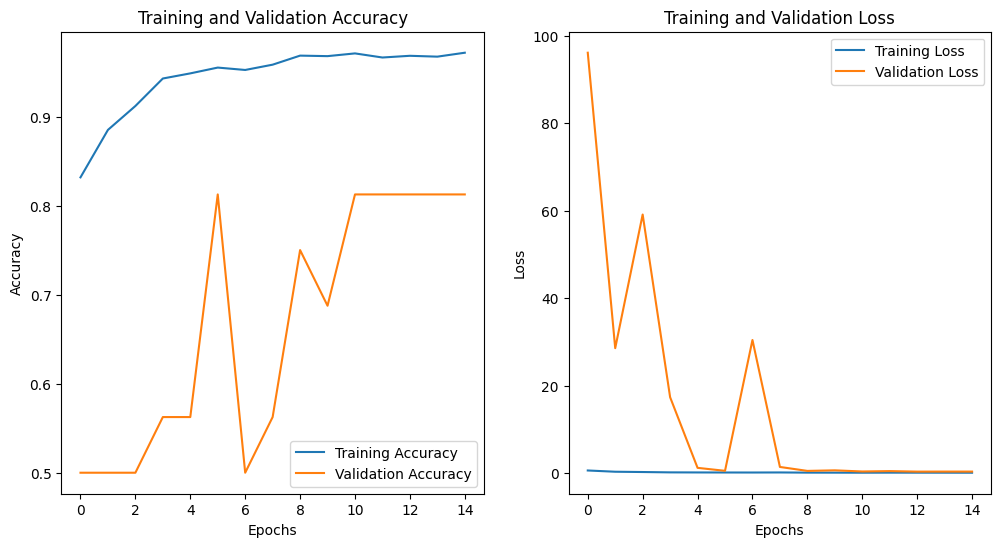

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


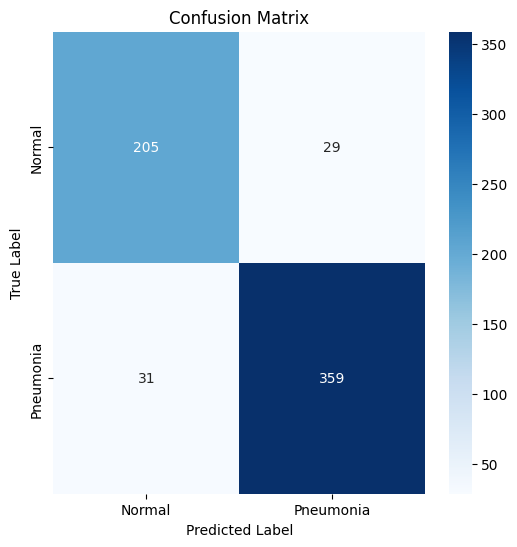

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the labels on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


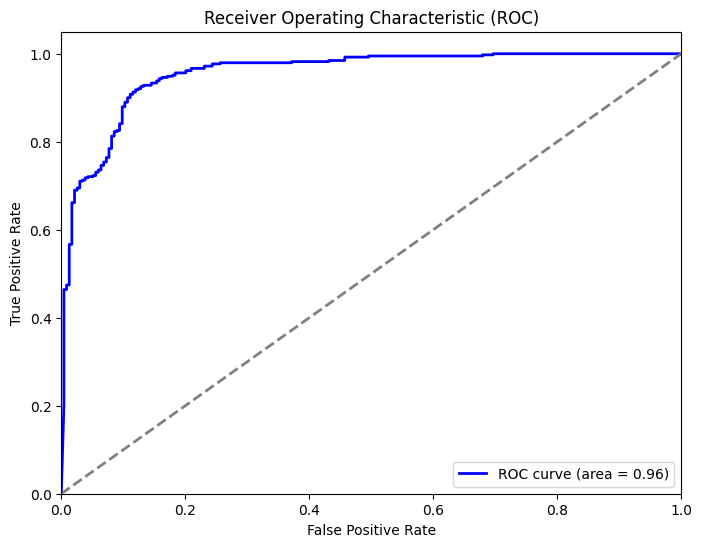

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.87      0.88      0.87       234
   Pneumonia       0.93      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624

